In [25]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import svm # the classifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, classification_report,ConfusionMatrixDisplay # for model evaluation
import matplotlib.pyplot as plt
from sklearn import datasets
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [26]:
digits = datasets.load_digits()

In [27]:
min(digits.target), max(digits.target)

(0, 9)

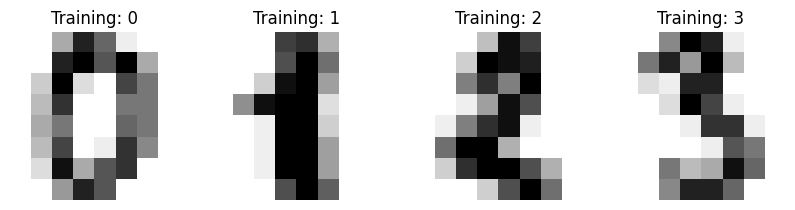

In [28]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [29]:
import time
import dill
import os 
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import KAN_NN_fast
import importlib
importlib.reload(KAN_NN_fast)



<module 'KAN_NN_fast' from 'c:\\Users\\JP\\Documents\\TU Berlin\\Master\\Code_clean\\AAAA\\KAN_NN_fast.py'>

In [30]:
import torch
y = torch.tensor(digits.target).long()
y_one_hot = torch.nn.functional.one_hot(y, num_classes=10)
print(y_one_hot.shape)

torch.Size([1797, 10])


In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
def get_loader():
    # Set the seed for reproducibility
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)
    digits = datasets.load_digits()
    print(digits.keys())

    # Generate the Friedman dataset
    X = torch.tensor(digits.data, dtype=torch.float32)
    y = torch.tensor(digits.target).long()
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=10).unsqueeze(-1)

    X_train, X_test, y_train, y_test = train_test_split(X,y_one_hot, test_size = 0.2, random_state=365, stratify=y)

    # Apply feature scaling (Standardization) ONLY to `X`
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)  # Fit and transform training data
    X_test = scaler_X.transform(X_test)        # Transform test data (using train stats)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = y_train.clone().detach().float()  # Keep `y` unchanged
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = y_test.clone().detach().float()    # Keep `y` unchanged

    # Create TensorDataset for train and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Set batch size and create DataLoader for training and testing
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000000, shuffle=False)

    return train_loader, test_loader

In [32]:
import torch.nn as nn
class Neural_Kan(nn.Module):
    """
    Class:
    shape: list, describing tuple (n_1,...,n_N)
    h: shape of univariate Neural Networks. 
    """
    def __init__(self, shape, h, device = None):
        super(Neural_Kan, self).__init__()
        self.train_loss = []
        self.test_loss = []
        self.layers = nn.Sequential()
        self.softmax = nn.Identity()#nn.Softmax(dim=1)
        for i in range(len(shape) - 1):
            self.layers.append(KAN_NN_fast.KAN_layer(in_dim = shape[i], out_dim = shape[i + 1], hidden = h))

    def forward(self,x):
        if x.shape[0] == 1:
            out = self.layers(x)
            return self.softmax(out).squeeze().unsqueeze(-1).unsqueeze(0)
        out = self.layers(x).squeeze()
        return self.softmax(out).unsqueeze(-1)
        


In [33]:
shape = [64, 16, 10]
model = Neural_Kan(shape = shape, h = [16])
input = torch.tensor(digits.data[:1], dtype=torch.float32)#.unsqueeze(-1)
print(input.shape)
print(model(input))



torch.Size([1, 64])
tensor([[[-2.1068e-03],
         [ 3.3186e-04],
         [ 2.1267e-03],
         [-1.0105e-03],
         [ 3.1079e-04],
         [-9.5574e-05],
         [ 2.3823e-03],
         [-4.8277e-04],
         [ 5.2420e-04],
         [-1.5538e-03]]], grad_fn=<UnsqueezeBackward0>)


In [34]:
@torch.no_grad()
def compute_test_loss(test_loader, model):
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.
    for batch, target in test_loader:
        outputs = model(batch)
        loss = criterion(target, outputs)
        running_loss += loss.item()
    return running_loss / len(test_loader)

In [35]:
train_loader, test_loader = get_loader()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


Neural_Kan(
  (layers): Sequential(
    (0): KAN_layer(
      (layers): Sequential(
        (0): Input_Linear()
        (1): Output_Linear()
      )
    )
    (1): KAN_layer(
      (layers): Sequential(
        (0): Input_Linear()
        (1): Output_Linear()
      )
    )
  )
  (softmax): Identity()
)
tensor([[  15.9551],
        [  15.6670],
        [ -69.6667],
        [ -47.7355],
        [ 120.0088],
        [  -0.3899],
        [  37.5992],
        [  79.4610],
        [-139.4365],
        [   0.5152]], grad_fn=<SliceBackward0>) tensor([4])
Epoch [1/1000], Loss: 0.000431, test: 1.000000, lr: 0.001000, time = 0.21599721908569336
tensor([[ -0.9442],
        [ 11.0079],
        [ 35.0001],
        [ -9.2398],
        [ -4.2753],
        [-38.0928],
        [ -3.3076],
        [ 14.1479],
        [ 16.9899],
        [-10.8453]], grad_fn=<SliceBackward0>) tensor([2])
Epoch [2/1000], Loss: 0.000196, test: 1.000000, lr: 0.001000, time = 0.24100208282470703
tensor([[ -9.5394],
        [ 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([[ -2.9649],
        [ -8.0789],
        [ 55.4176],
        [ 28.9415],
        [-15.3410],
        [106.6053],
        [-26.5966],
        [ 33.1088],
        [ -6.7510],
        [ 10.1342]], grad_fn=<SliceBackward0>) tensor([5])
Epoch [1000/1000], Loss: 0.000003, test: 1.000000, lr: 0.001000, time = 0.2220003604888916


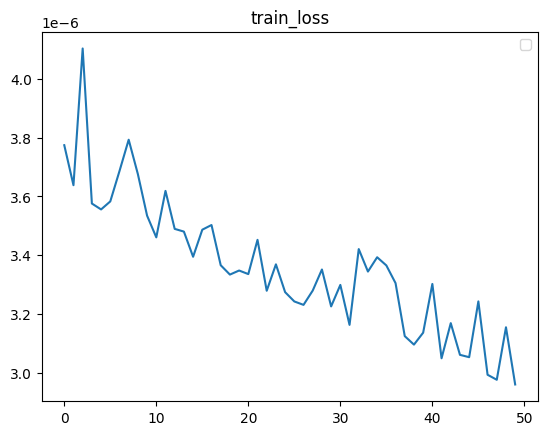

Training Complete!


In [52]:
import torch.optim as optim
epochs = 1000
train_losses = []
test_losses = []
model.train()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print(model)
for epoch in range(epochs):
    running_loss = 0.0
    start_time = time.time()
    for count, (batch, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(batch)
        targets = target.argmax(dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(outputs[1,:], targets[1,:])
    end_time = time.time()
    avg_loss = running_loss / len(train_loader)
    model.train_loss.append(avg_loss)
    test_l = compute_test_loss(test_loader, model)
    model.test_loss.append(test_l)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, test: {test_l:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}, time = {end_time - start_time}")
plt.plot(model.train_loss[-50:])
plt.title(f'train_loss')
plt.legend()
plt.show()
print("Training Complete!")



In [45]:
def Xy_test():
    # Set the seed for reproducibility
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)
    digits = datasets.load_digits()
    print(digits.keys())

    # Generate the Friedman dataset
    X = torch.tensor(digits.data, dtype=torch.float32)
    y = torch.tensor(digits.target)
    #y_one_hot = torch.nn.functional.one_hot(y, num_classes=10).unsqueeze(-1)

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=365, stratify=y)

    # Apply feature scaling (Standardization) ONLY to `X`
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)  # Fit and transform training data
    X_test = scaler_X.transform(X_test)        # Transform test data (using train stats)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = y_test.clone().detach().float()    # Keep `y` unchanged
    return X_test_tensor, y_test_tensor
X_test, y_test = Xy_test()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [46]:
X_test.shape

torch.Size([360, 64])

In [47]:
predicition = model(X_test).squeeze()

In [48]:
softmax = nn.Softmax(dim = 1)
predicition = softmax(predicition)

In [41]:
predicition

tensor([[1.4290e-08, 1.1570e-13, 9.1436e-21,  ..., 1.3408e-26, 6.0829e-14,
         1.5175e-17],
        [1.0000e+00, 2.0071e-16, 1.9687e-23,  ..., 7.2244e-21, 1.5935e-17,
         1.3951e-15],
        [6.4145e-15, 7.3442e-08, 3.5023e-08,  ..., 9.9975e-01, 2.2064e-08,
         6.7239e-14],
        ...,
        [4.9243e-08, 7.8663e-10, 1.2742e-04,  ..., 1.8599e-04, 5.3552e-20,
         2.3524e-07],
        [1.7084e-34, 1.0698e-27, 1.0000e+00,  ..., 2.7965e-39, 4.3983e-21,
         2.2975e-26],
        [4.6937e-25, 2.0584e-28, 1.8919e-22,  ..., 2.7491e-31, 3.8887e-12,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [49]:
yhat = torch.argmax(predicition, dim = 1)
print(yhat.shape)
yhat[0:5]

torch.Size([360])


tensor([6, 0, 7, 9, 0])

In [50]:
y_test[:5]

tensor([6., 0., 7., 4., 0.])

Avg F1-score: 0.9611
Accuracy: 0.9611
Precision: 0.9611
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.95      0.97      0.96        37
           2       0.97      0.97      0.97        35
           3       0.95      0.97      0.96        37
           4       1.00      0.92      0.96        36
           5       1.00      1.00      1.00        36
           6       1.00      1.00      1.00        36
           7       0.92      1.00      0.96        36
           8       0.91      0.91      0.91        35
           9       0.91      0.89      0.90        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



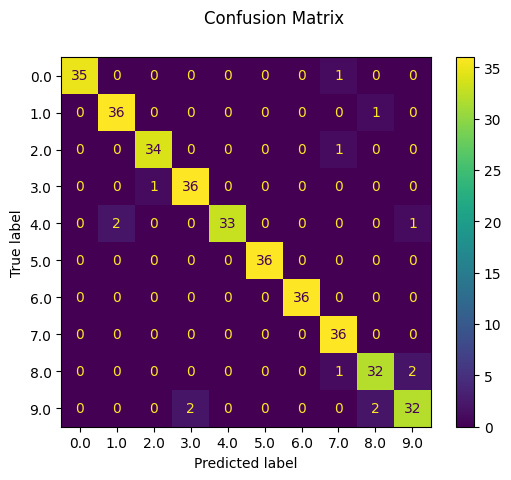

Confusion matrix:
[[35  0  0  0  0  0  0  1  0  0]
 [ 0 36  0  0  0  0  0  0  1  0]
 [ 0  0 34  0  0  0  0  1  0  0]
 [ 0  0  1 36  0  0  0  0  0  0]
 [ 0  2  0  0 33  0  0  0  0  1]
 [ 0  0  0  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  1 32  2]
 [ 0  0  0  2  0  0  0  0  2 32]]


In [51]:
f1 = f1_score(y_test, yhat, average='weighted')
accuracy = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average='micro')

print("Avg F1-score: %.4f" % f1)
print("Accuracy: %.4f" % accuracy)
print("Precision: %.4f" % precision)

from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(y_test, yhat,labels=np.unique(yhat)))
disp = ConfusionMatrixDisplay.from_predictions(y_test, yhat)
disp.figure_.suptitle("Confusion Matrix")

plt.show()


print(f"Confusion matrix:\n{disp.confusion_matrix}")